<a href="https://colab.research.google.com/github/Strugoeden121/DataScience236006-Final/blob/main/proj_eden_added%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load the csv file of the adult-income-dataset csv adult.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the adult dataset
adult_dataset = pd.read_csv('./adult.csv')

In [2]:
# Drop all the columns that are not in the relevant features
relevant_features = ['age', 'gender', 'race', 'native-country', 'income']
adult_dataset = adult_dataset[[col for col in adult_dataset.columns if col in relevant_features]]

# Replace missing values denoted by '?' with NaN
adult_dataset.replace('?', np.nan, inplace=True)

# Drop rows with missing values
adult_dataset.dropna(inplace=True)

# Reset index after dropping rows
adult_dataset.reset_index(drop=True, inplace=True)

# Display the first few rows
print(adult_dataset.head())

   age   race  gender native-country income
0   25  Black    Male  United-States  <=50K
1   38  White    Male  United-States  <=50K
2   28  White    Male  United-States   >50K
3   44  Black    Male  United-States   >50K
4   18  White  Female  United-States  <=50K


### Find Underrepresented groups
#### We will check for a two feature combinations from: 'race', 'native-country', 'gender', 'age'

In [3]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

def plot_heatmap_categorical(data, value1, value2):
    # Create a cross-tabulation of the two categorical values
    crosstab = pd.crosstab(data[value1], data[value2])

    # Calculate the frequency of each category
    freq = crosstab.apply(lambda r: r / r.sum(), axis=1)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    if len(crosstab.columns) > 5:
        num_subplots = len(crosstab.columns) // 5 + 1
        fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))
        for i in range(num_subplots):
            start_idx = i * 5
            end_idx = min((i + 1) * 5, len(crosstab.columns))
            sub_crosstab = crosstab.iloc[:, start_idx:end_idx]
            ax = axes[i] if num_subplots > 1 else axes
            sns.heatmap(sub_crosstab, annot=True, fmt='d', cmap='RdBu', linewidths=0.5, linecolor='white', ax=ax, vmin=crosstab.min().min(), vmax=crosstab.max().max())
            ax.set_title(f'Counts of {value1} and {value2} (Part {i+1})')
            ax.set_xlabel(value2)
            ax.set_ylabel(value1)
        plt.tight_layout()
    else:
        sns.heatmap(crosstab, annot=True, fmt='d', cmap='RdBu', linewidths=0.5, linecolor='white', vmin=crosstab.min().min(), vmax=crosstab.max().max())
        plt.title(f'Counts of {value1} and {value2}')
        plt.xlabel(value2)
        plt.ylabel(value1)
    plt.show()

Find Underrepresented groups for race and gender

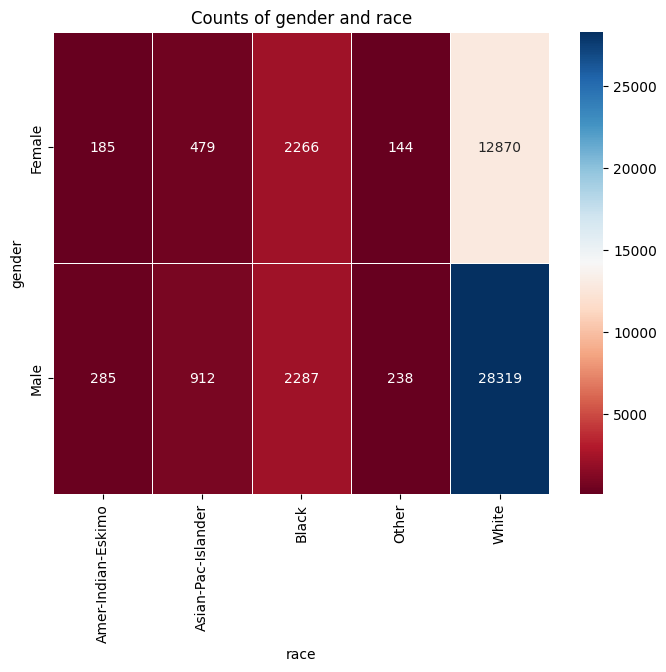

In [4]:
plot_heatmap_categorical(adult_dataset, 'gender', 'race')

We see general underrepresentation for Amer-Indian-Eskimo.
We also see underrepresentation for female Asian-Pac-Islander

<Figure size 800x600 with 0 Axes>

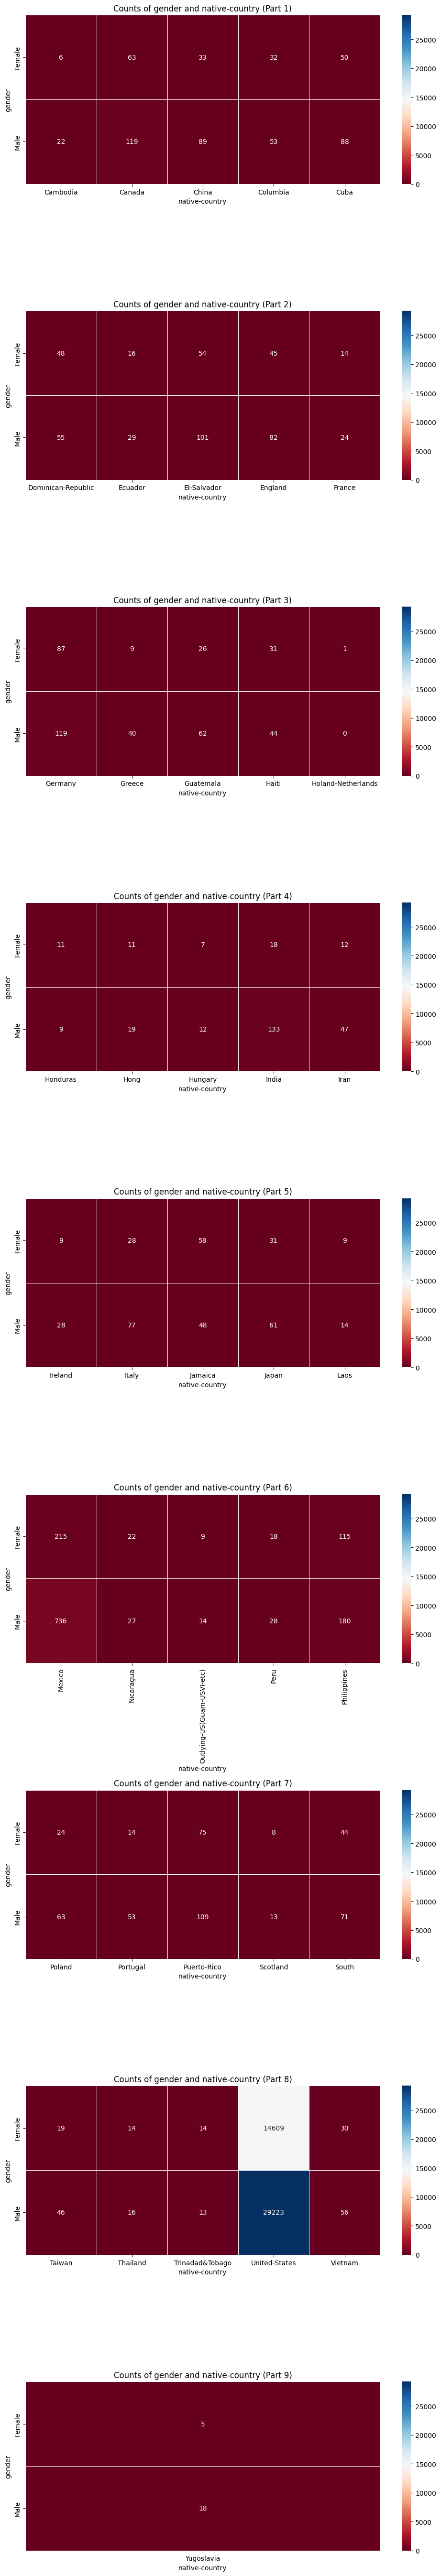

In [5]:
plot_heatmap_categorical(adult_dataset, 'gender', 'native-country')

We see that the United States is the most common native-country and it makes hard to understand the heatmap.
Lets understand if in general non-United-States is underrepresented.

In [6]:
# Calculate the pretcentage of non US citizens
non_us_citizens = adult_dataset[adult_dataset['native-country'] != 'United-States']
percentage = len(non_us_citizens) / len(adult_dataset) * 100
print(f'{percentage:.2f}% of the dataset are non US citizens')
print(f'the number of non US citizens is {len(non_us_citizens)}')

8.65% of the dataset are non US citizens
the number of non US citizens is 4153


There are 3930 non-US citizens samples in the data, which are 8.69%. For now we are not considering this entire category as underrepresented.
And so we now will enlarge the resolution.

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Figure size 800x600 with 0 Axes>

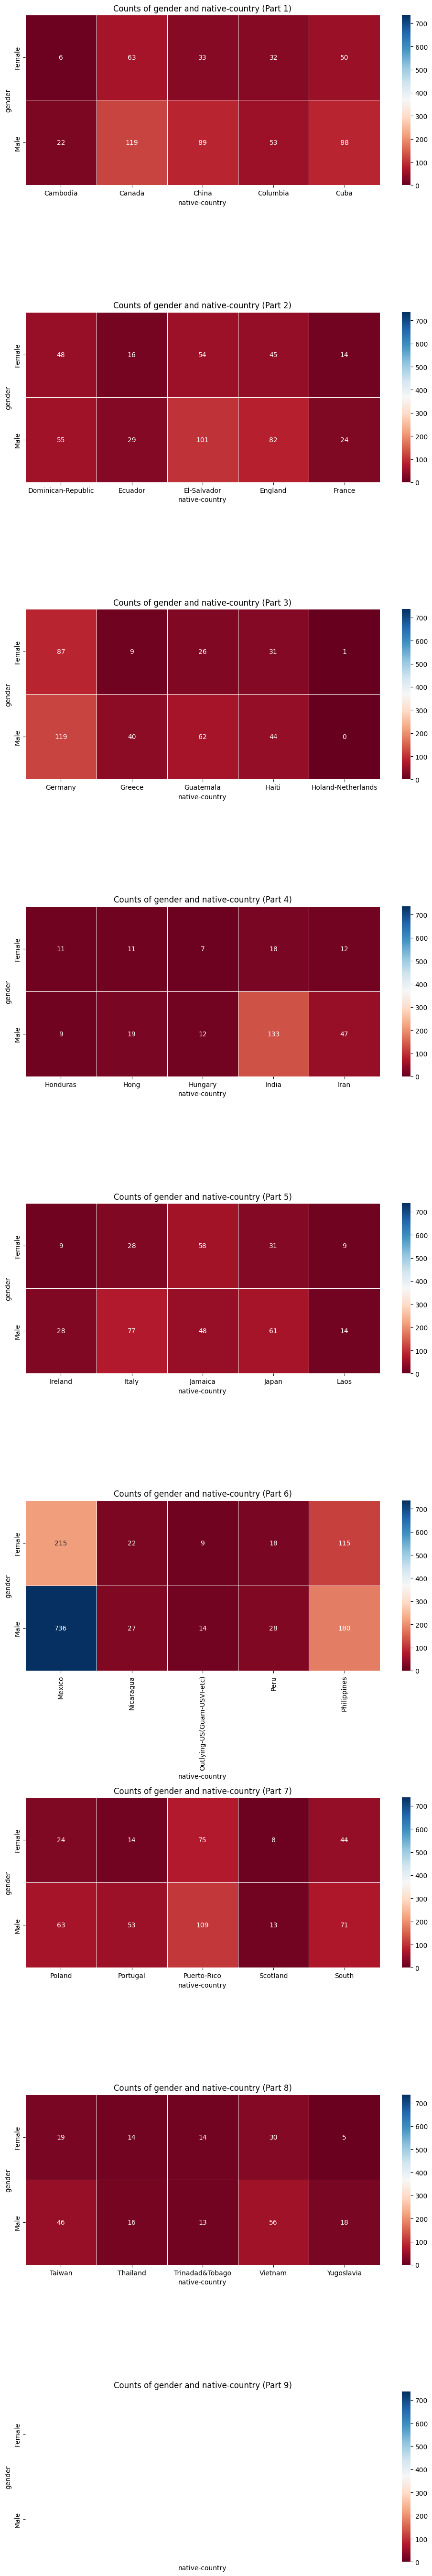

In [7]:
plot_heatmap_categorical(non_us_citizens, 'gender', 'native-country')

It is obvious now that each native-country other than the US (and maybe Mexico) can be considered underrepresented.
We will explore two options to continue.
The first is binning native-country into continents
The second is defining those all as underrepresented when synthesizing the new samples, and prompt the LLM to create samples for all non-US native-countries.

Because the native-countries is so split, we will move forward with the bins for now, especially when trying to find underrepresentation

In [8]:
def map_country_to_continent(country):
    continent_map = {
        'North America': ['United-States', 'Canada', 'Mexico','Outlying-US(Guam-USVI-etc)',],
        'Central America': [ 'Puerto-Rico', 'Honduras', 'Cuba', 'Dominican-Republic', 'Jamaica', 'El-Salvador', 'Haiti', 'Trinadad&Tobago'],
        'Asia': ['China', 'India', 'Japan', 'Philippines', 'Vietnam', 'South'],
        'Europe': ['England', 'Germany', 'Italy', 'Poland', 'Portugal', 'France', 'Greece', 'Ireland'],
        'South America': ['Columbia', 'Ecuador', 'Peru']
    }

    for continent, countries in continent_map.items():
        if country in countries:
            return continent
    return 'Other'

adult_dataset['continent'] = adult_dataset['native-country'].apply(map_country_to_continent)

<Figure size 800x600 with 0 Axes>

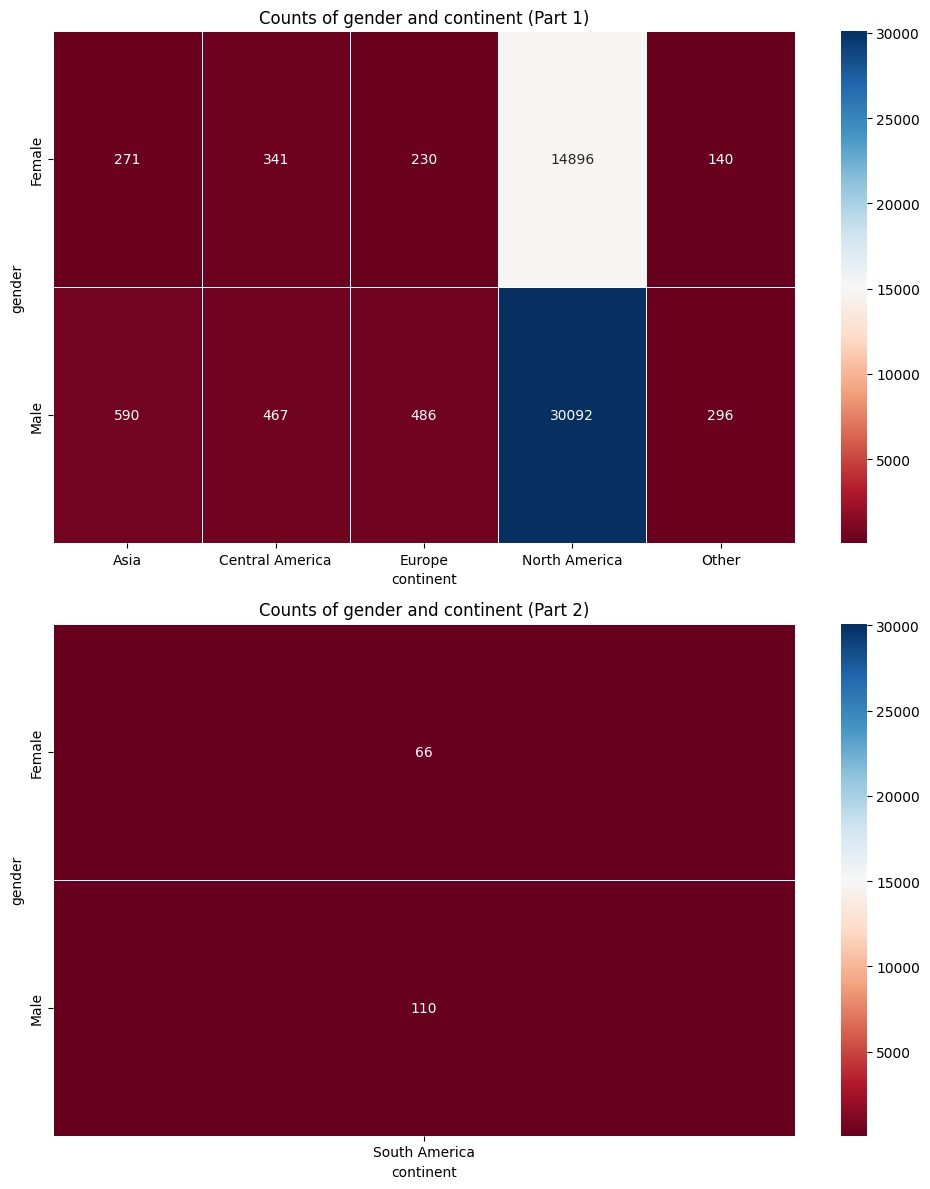

In [9]:
plot_heatmap_categorical(adult_dataset, 'gender', 'continent')

We again see that the US (North America) is by far the most represented, even after binning into continents.
We will remove the North-America like we did before to better visualize the data

<ipython-input-10-5418bf380d88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_us_citizens['continent'] = non_us_citizens['native-country'].apply(map_country_to_continent)


<Figure size 800x600 with 0 Axes>

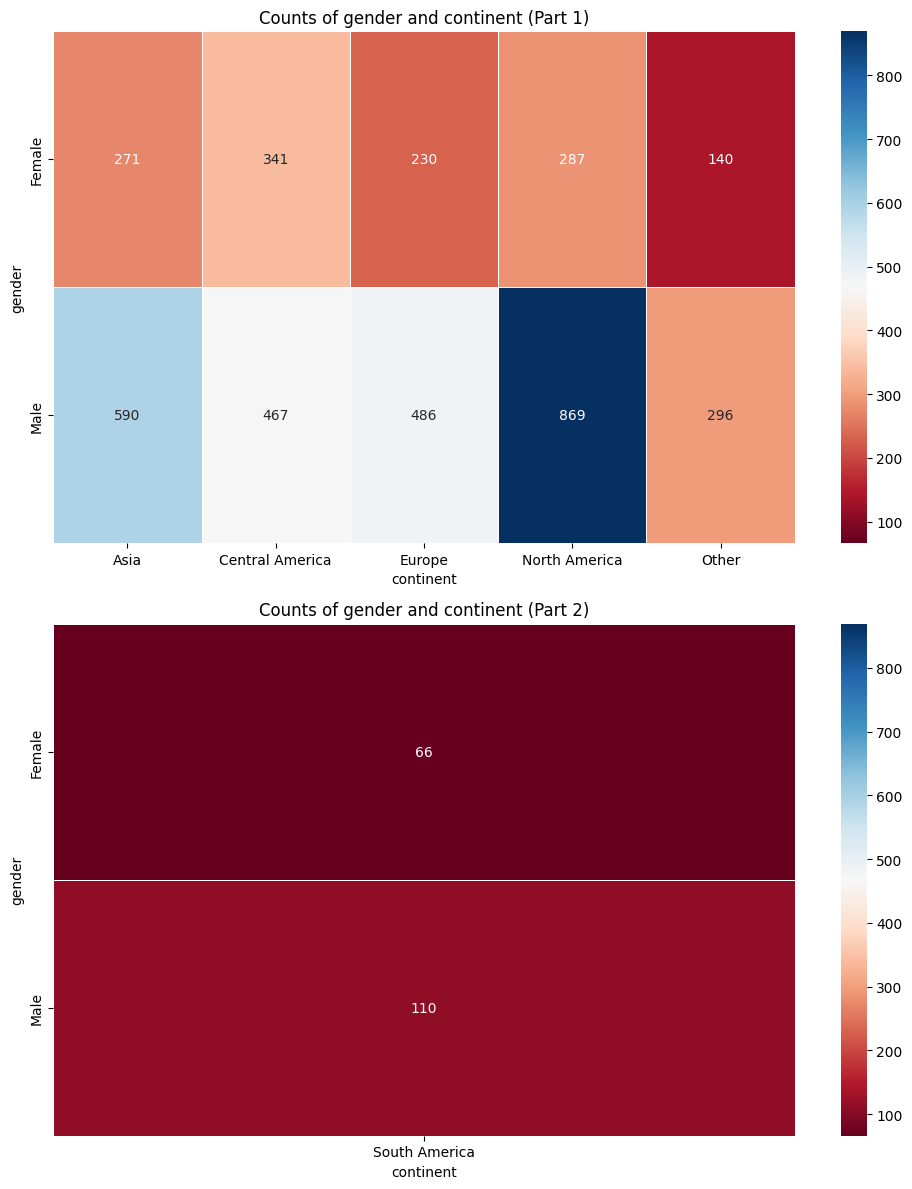

In [10]:
non_us_citizens['continent'] = non_us_citizens['native-country'].apply(map_country_to_continent)
plot_heatmap_categorical(non_us_citizens, 'gender', 'continent')

We now see that South America is the underrepresented continent.
There is not much of a difference there between male and Female. And so we conclude that the entire South America continent as underrepresented


We will now check for race and continent

<Figure size 800x600 with 0 Axes>

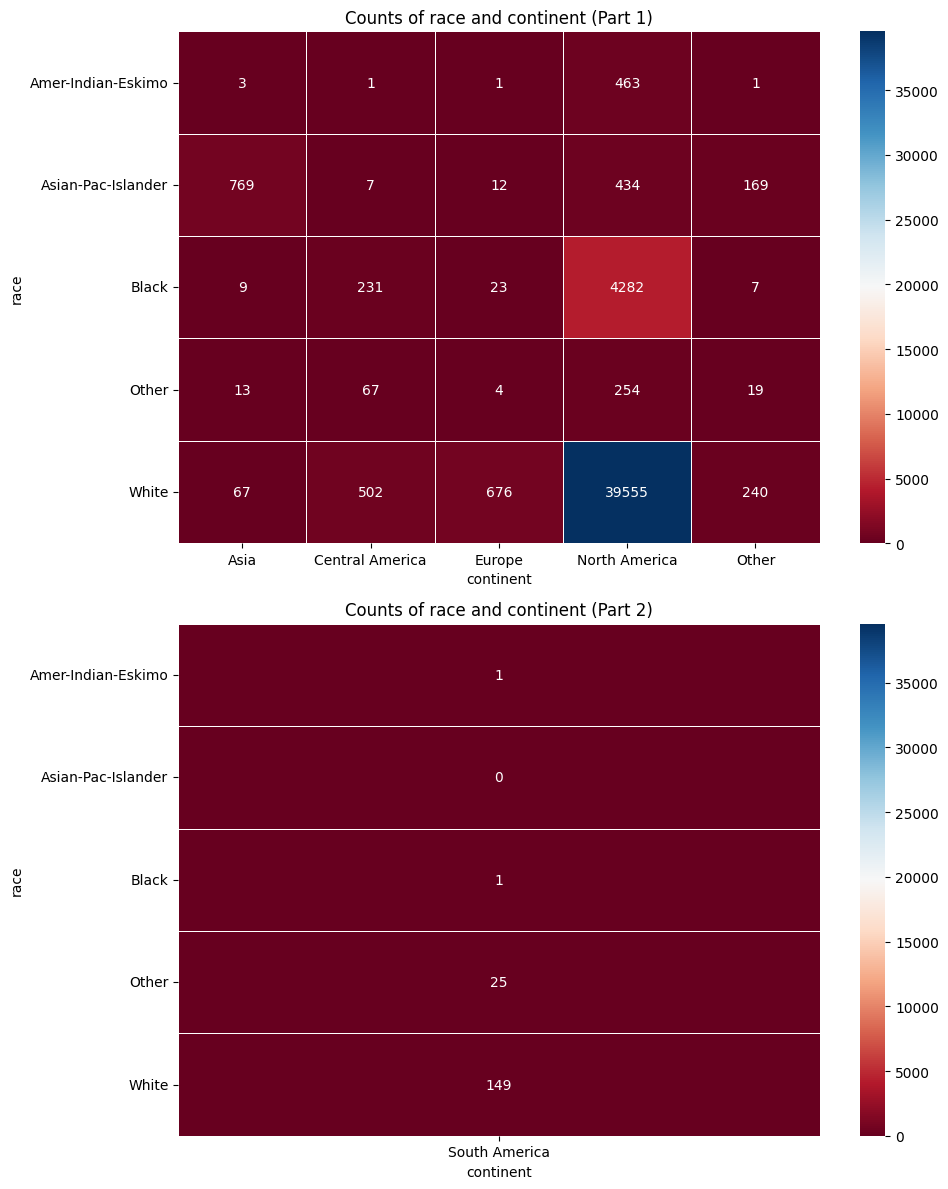

In [11]:
plot_heatmap_categorical(adult_dataset, 'race', 'continent')

We see that Asia white peaple and Asia black people are underrepresented!

We will now check underrepresented groups for age combinations.
We will first bin the age to categories

In [12]:
# Bin the age column into different age groups that are more interpretable and meaningful in regards to income
kids_range = range(0, 18)
young_adults_range = range(18, 30)
adults_range = range(30, 50)
middle_aged_range = range(50, 65)
senior_range = range(65, 100)

def map_age_to_group(age):
    if age in kids_range:
        return 'Kids'
    elif age in young_adults_range:
        return 'YoungAdults'
    elif age in adults_range:
        return 'Adults'
    elif age in middle_aged_range:
        return 'MiddleAged'
    elif age in senior_range:
        return 'Senior'
    else:
        return 'Other'

adult_dataset['agegroup'] = adult_dataset['age'].apply(map_age_to_group)

adult_dataset.drop(['age', 'native-country'], axis=1, inplace=True)

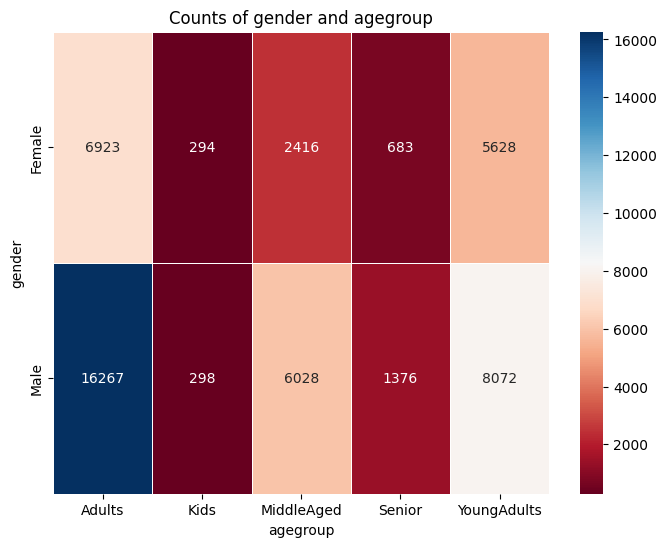

In [13]:
plot_heatmap_categorical(adult_dataset, 'gender', 'agegroup')

We found no underrepresented group. Now we will check for age and race

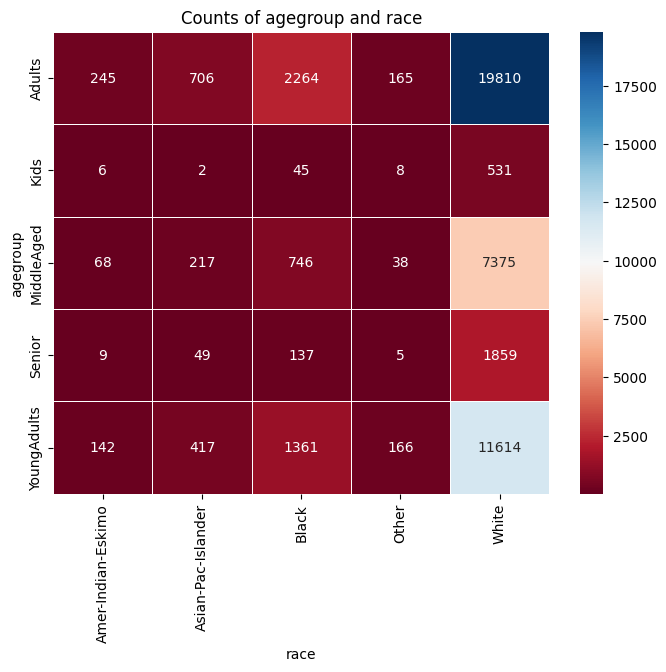

In [14]:
plot_heatmap_categorical(adult_dataset, 'agegroup', 'race')

We see underrepresentation for all non-white kids! (448 white kids vs 45 non white kids). meaning non-white kids are only 0.1% of the data.

<Figure size 800x600 with 0 Axes>

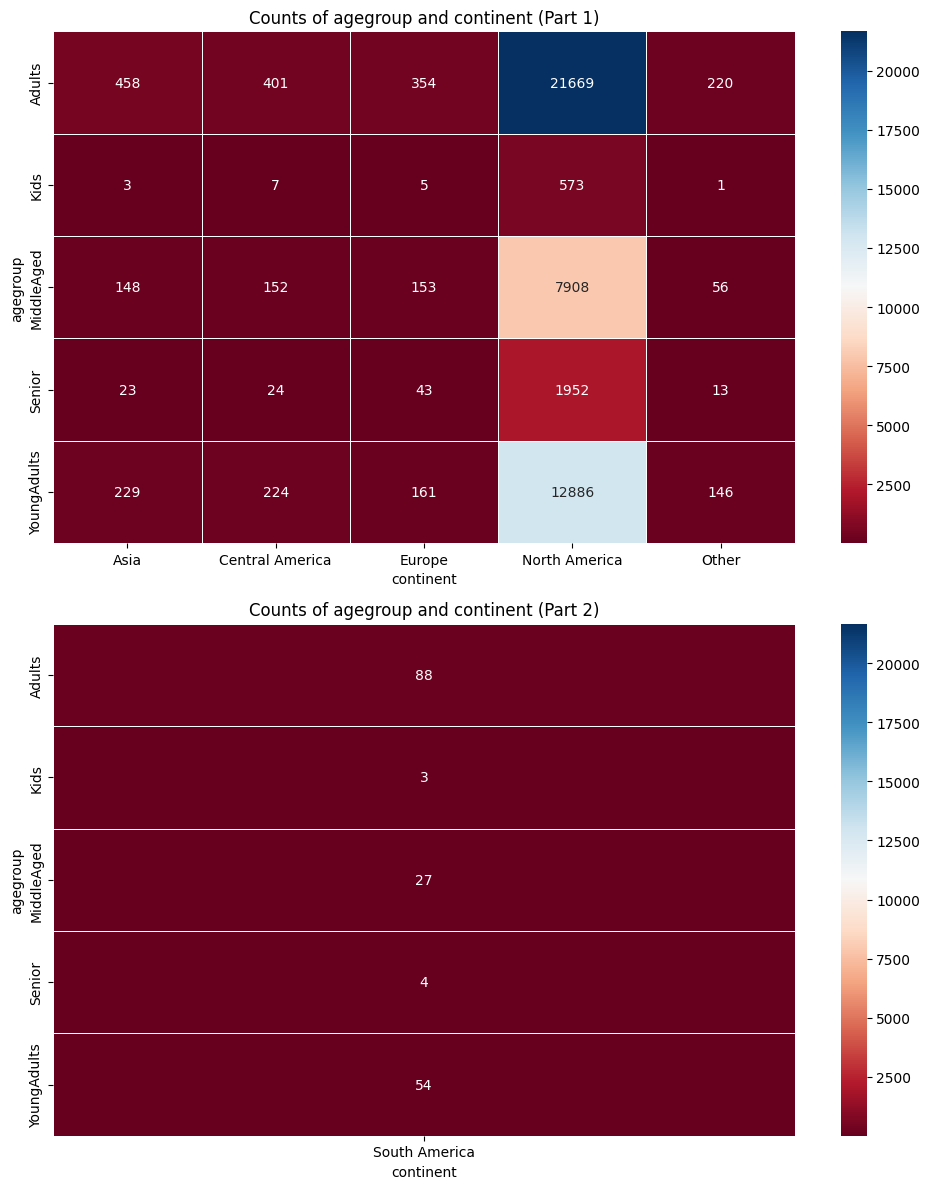

In [15]:
plot_heatmap_categorical(adult_dataset, 'agegroup', 'continent')

We see that seniors that aren't North America are underrepresented. We can take Asia-Seniors as an underrepresentred group.

We found underrepresented groups. We will now calculate the weights of the causal dag containing only the agegroup, continent, race, gender and income nodes.

5 5
True


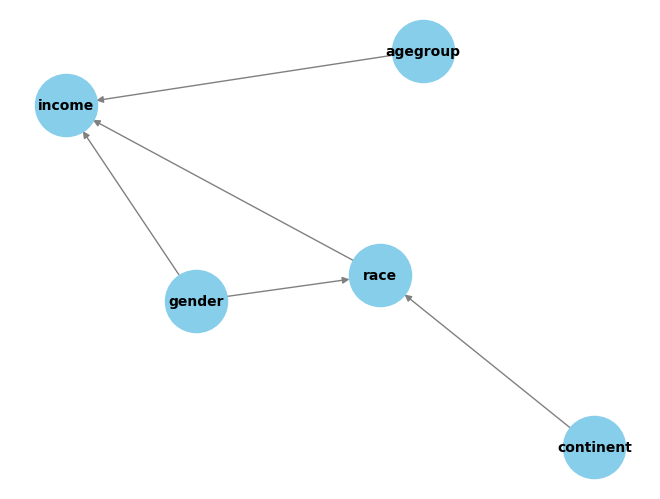

In [16]:
import networkx as nx

dag_data = [
    ('age', 'education_num'),
    ('age', 'hours_per_week'),
    ('age', 'income'),
    ('age', 'income'),
    ('age', 'marital_status'),
    ('age', 'marital_status'),
    ('age', 'occupation'),
    ('age', 'relationship'),
    ('age', 'work_class'),
    ('education_num', 'education'),
    ('education_num', 'hours_per_week'),
    ('education_num', 'income'),
    ('education_num', 'income'),
    ('education_num', 'occupation'),
    ('education_num', 'work_class'),
    ('education_num', 'work_class'),
    ('hours_per_week', 'income'),
    ('hours_per_week', 'relationship'),
    ('income', 'education'),
    ('marital_status', 'education_num'),
    ('marital_status', 'hours_per_week'),
    ('marital_status', 'income'),
    ('marital_status', 'occupation'),
    ('marital_status', 'work_class'),
    ('marital_status', 'work_class'),
    ('native-countryountry', 'education'),
    ('native-countryountry', 'education_num'),
    ('native-countryountry', 'education_num'),
    ('native-countryountry', 'hours_per_week'),
    ('native-countryountry', 'income'),
    ('native-country', 'marital_status'),
    ('native-country', 'occupation'),
    ('native-country', 'race'),
    ('native-country', 'work_class'),
    ('occupation', 'education'),
    ('occupation', 'income'),
    ('occupation', 'occupation_category'),
    ('occupation_category', 'education'),
    ('occupation_category', 'work_class'),
    ('race', 'education_num'),
    ('race', 'hours_per_week'),
    ('race', 'income'),
    ('race', 'income'),
    ('race', 'marital_status'),
    ('race', 'occupation'),
    ('race', 'work_class'),
    ('race', 'work_class'),
    ('gender', 'education_num'),
    ('gender', 'hours_per_week'),
    ('gender', 'income'),
    ('gender', 'income'),
    ('gender', 'marital_status'),
    ('gender', 'occupation'),
    ('gender', 'race'),
    ('gender', 'relationship'),
    ('gender', 'work_class'),
    ('gender', 'work_class'),
    ('work_class', 'income'),
]

# keep only unique tuples
dag_data = list(set(dag_data))
# keep only tupples with both nodes conatained in the features: [age, gender, race, native-country, income]
dag_data = [row for row in dag_data if row[0] in relevant_features and row[1] in relevant_features]
# rename native-country to continent and age to agegroup
dag_data = [(row[0].replace('native-country', 'continent').replace('age', 'agegroup'), row[1].replace('native-country', 'continent').replace('age', 'agegroup')) for row in dag_data]

outcome_node = 'income'
treatment_node_to_possible_treatments = {
    'agegroup': ['YoungAdults', 'Adults', 'MiddleAged', 'Senior', 'Kids'],
    'continent': ['North America', 'Central America', 'Asia', 'Europe', 'South America', 'Other'],
    'race': ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],
    'gender': ['Male', 'Female']}
    # 'income': ['<=50K', '>50K']}

# categorical_cols = ['agegroup', 'continent', 'race', 'gender', 'income']
# print()
# # convert the categorical columns to one-hot encoding
# adult_dataset = pd.get_dummies(adult_dataset, columns=categorical_cols, drop_first=True)
# for dag_data_edge in dag_data:
#     if dag_data_edge[0] in categorical_cols:
#         dag_data += [(f'{dag_data_edge[0]}_{treatment}', dag_data_edge[1]) for treatment in treatment_node_to_possible_treatments[dag_data_edge[0]]]
#     if dag_data_edge[1] in categorical_cols:
#         dag_data += [(dag_data_edge[0], f'{dag_data_edge[1]}_{treatment}') for treatment in treatment_node_to_possible_treatments[dag_data_edge[1]]]

# edit the dag to include the one-hot encoded columns
dag = nx.DiGraph(dag_data)
print(len(dag.nodes), len(dag.edges))

print(nx.is_directed_acyclic_graph(dag))
# Draw the dag

nx.draw(dag, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', pos=nx.spring_layout(dag))

In [17]:
!pip install dowhy

In [18]:
# For each node in the DAG, calculate the ATE of each possible treatment on the income feature, using dowhy
import dowhy
from dowhy import CausalModel
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def is_treatment_significant(causal_estimate):
    p_value = causal_estimate.test_stat_significance()['p_value']
    # try :
    return p_value is not None and p_value < 0.05
    # except:
    #     return p_value[0] < 0.05


def get_treatment_to_casual_estimate_dict(origin_dataset, dag, treatment_node_to_possible_treatments):
    # change the income column to binary
    adult_dataset = origin_dataset.copy()
    adult_dataset['income'] = adult_dataset['income'].apply(lambda x: 1 if x == '>50K' else -1)
    treatment_to_casual_estimate_dict = {}
    for treatment_node, possible_treatments in treatment_node_to_possible_treatments.items():
        for treatment in possible_treatments:
            dataset = adult_dataset.copy()
            dataset[treatment_node] = dataset[treatment_node].apply(lambda x: 1 if x == treatment else 0)
            # print the number of rows for each treatment
            print(f'{treatment_node}={treatment} : {len(dataset[dataset[treatment_node] == 1])}')
            print(f'{treatment_node}!= {treatment} : {len(dataset[dataset[treatment_node] == 0])}')
            model = CausalModel(
                data=dataset,
                treatment=treatment_node,
                outcome=outcome_node,
                graph=dag
            )
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.linear_regression",
                                            target_units="ate",
                                            effect_modifiers = [],
                                            test_significance=True,
                                            )
            # check if the treatment is significant
            if is_treatment_significant(causal_estimate):
                print(f'Treatment: {treatment_node}={treatment}, ATE: {causal_estimate.value}')
            else :
                print(f'Treatment: {treatment_node}={treatment}, ATE: Not significant, p-value: {causal_estimate.test_stat_significance()["p_value"]}')
            treatment_to_casual_estimate_dict[(treatment_node, treatment)] = causal_estimate

    return treatment_to_casual_estimate_dict



In [19]:
!pip install scikit-learn==1.1.3


In [20]:
treatment_to_casual_estimate_dict = get_treatment_to_casual_estimate_dict(adult_dataset, dag, treatment_node_to_possible_treatments)

agegroup=YoungAdults : 13700
agegroup!= YoungAdults : 34285
Treatment: agegroup=YoungAdults, ATE: -0.5193600657434582
agegroup=Adults : 23190
agegroup!= Adults : 24795
Treatment: agegroup=Adults, ATE: 0.2944669967732836
agegroup=MiddleAged : 8444
agegroup!= MiddleAged : 39541
Treatment: agegroup=MiddleAged, ATE: 0.28459886050793703
agegroup=Senior : 2059
agegroup!= Senior : 45926
Treatment: agegroup=Senior, ATE: -0.07209833112655495
agegroup=Kids : 592
agegroup!= Kids : 47393
Treatment: agegroup=Kids, ATE: -0.4839111261156691
continent=North America : 44988
continent!= North America : 2997
Treatment: continent=North America, ATE: 0.03857520719795249
continent=Central America : 808
continent!= Central America : 47177
Treatment: continent=Central America, ATE: -0.2393978900189877
continent=Asia : 861
continent!= Asia : 47124
Treatment: continent=Asia, ATE: 0.0857343676568939
continent=Europe : 716
continent!= Europe : 47269
Treatment: continent=Europe, ATE: 0.11880375376825242
continent=

In [21]:
def check_synthesized_samples_effect(dataset, dag, treatment_node_to_possible_treatments, treatment_to_casual_estimate_dict, synthesized_samples_file_path):
    # Load the synthesized samples csv
    synthesized_samples = pd.read_csv(synthesized_samples_file_path)
    # Take only the relevant features
    synthesized_samples = synthesized_samples[[col for col in synthesized_samples.columns if col in dataset.columns]]
    data = dataset.copy()
    data = pd.concat([data, synthesized_samples])
    treatment_to_casual_estimate_dict_synthesized = get_treatment_to_casual_estimate_dict(data, dag, treatment_node_to_possible_treatments)
    for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items():
        print(f'Treatment: {treatment[0]}={treatment[1]}, ATE: {causal_estimate.value}')
        print(f'Actual ATE: {treatment_to_casual_estimate_dict[treatment].value}')
        print(f'Error: {abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value)}')

    # Print the treatment with the highest error
    errors = [abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value)
                     for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items()
                     if is_treatment_significant(causal_estimate) and is_treatment_significant(treatment_to_casual_estimate_dict[treatment])]

    max_error = max(errors)
    print(f'Max error: {max_error}')
    print(f'Treatment with max error: {[treatment for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items() if abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value) == max_error]}')
    min_error = min(errors)
    print(f'Min error: {errors}')
    print(f'Treatment with min error: {[treatment for treatment, causal_estimate in treatment_to_casual_estimate_dict_synthesized.items() if abs(causal_estimate.value - treatment_to_casual_estimate_dict[treatment].value) == min_error]}')
    print(f'Mean error: {np.mean(errors)}')



In [23]:
# underrepresented_groups = ['Amer-Indian-Eskimo', 'Female_Asian-Pac-Islander', 'South-America', 'Asia-White', 'Asia-Black', 'Non-White_Kids', 'European_Young-Adults']
underrepresented_groups = ['European_Young-Adults']


for group in underrepresented_groups:
    synthesized_samples_file_path = f'./synthesized_samples_{group}.csv'
    check_synthesized_samples_effect(adult_dataset, dag, treatment_node_to_possible_treatments, treatment_to_casual_estimate_dict, synthesized_samples_file_path)

agegroup=YoungAdults : 13800
agegroup!= YoungAdults : 34285
Treatment: agegroup=YoungAdults, ATE: -0.5127431187425103
agegroup=Adults : 23190
agegroup!= Adults : 24895
Treatment: agegroup=Adults, ATE: 0.29171797963694124
agegroup=MiddleAged : 8444
agegroup!= MiddleAged : 39641
Treatment: agegroup=MiddleAged, ATE: 0.2831051032615049
agegroup=Senior : 2059
agegroup!= Senior : 46026
Treatment: agegroup=Senior, ATE: -0.07326933293420945
agegroup=Kids : 592
agegroup!= Kids : 47493
Treatment: agegroup=Kids, ATE: -0.48503990061693325
continent=North America : 44988
continent!= North America : 3097
Treatment: continent=North America, ATE: Not significant, p-value: [0.20941032]
continent=Central America : 808
continent!= Central America : 47277
Treatment: continent=Central America, ATE: -0.2405359230002585
continent=Asia : 861
continent!= Asia : 47224
Treatment: continent=Asia, ATE: 0.08458326373152569
continent=Europe : 816
continent!= Europe : 47269
Treatment: continent=Europe, ATE: 0.1708905

In [49]:
#function that changes the dag to take into account the treatment
def causal_dag_manipulation(dag_data, feature_1, feature_2):
    # Replace instances of feature_1 and feature_2 with 'combined_treatment'
    new_dag_data = []
    dag_data = list(dag_data.edges)
    print(dag_data)
    #for edge in dag_data:
    for source, target in dag_data:
        new_source = 'combined_treatment' if source in [feature_1, feature_2] else source
        new_target = 'combined_treatment' if target in [feature_1, feature_2] else target
        if (new_source == new_target): continue
        new_dag_data.append((new_source, new_target))

    # Create a directed graph using NetworkX
    dag_graph = nx.DiGraph()
    dag_graph.add_edges_from(new_dag_data)

    # Plot the new DAG
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(dag_graph)  # Position nodes using spring layout for better visualization
    nx.draw(dag_graph, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrows=True)
    plt.title('Modified Causal DAG with Combined Treatment', fontsize=16)
    plt.show()

    # Return the new DAG as a list of edges
    return new_dag_data


In [54]:
# Second Method - look at all values from the treatment feature and, calculate the ATE of each possible Combination to the income feature, using dowhy


def get_two_feature_combination_ate(origin_dataset, dag, feature_1, feature_2):
    # Change the income column to binary
    dataset = origin_dataset.copy()
    dataset['income'] = dataset['income'].apply(lambda x: 1 if x == '>50K' else -1)

    # Get unique possible values for both features
    possible_values_1 = origin_dataset[feature_1].unique()
    possible_values_2 = origin_dataset[feature_2].unique()

    #new_dag
    new_dag = causal_dag_manipulation(dag, feature_1, feature_2)
    dag = nx.DiGraph(new_dag)

    treatment_to_causal_estimate_dict = {}

    for value_1 in possible_values_1:
        for value_2 in possible_values_2:
            dataset_copy = dataset.copy()
            # Create a new column that is 1 if both features match the specific combination of values, otherwise 0
            dataset_copy['combined_treatment'] = dataset_copy.apply(lambda row: 1 if (row[feature_1] == value_1 and row[feature_2] == value_2) else 0, axis=1)

            # Drop feature_1 and feature_2 columns from the dataset
            dataset_copy = dataset_copy.drop([feature_1, feature_2], axis=1)

            # Print the number of rows where both features match
            print(f'{feature_1}={value_1}, {feature_2}={value_2}: {len(dataset_copy[dataset_copy["combined_treatment"] == 1])}')




            # Causal model
            model = CausalModel(
                data=dataset_copy,
                treatment='combined_treatment',
                outcome='income',
                graph=dag
            )

            # Identify and estimate the effect
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                target_units="ate",
                effect_modifiers=[],
                test_significance=True
            )

            # Check significance
            if is_treatment_significant(causal_estimate):
                print(f'Treatment: {feature_1}={value_1}, {feature_2}={value_2}, ATE: {causal_estimate.value}, p-value: {causal_estimate.test_stat_significance()["p_value"]}')
            else:
                print(f'Treatment: {feature_1}={value_1}, {feature_2}={value_2}, ATE: Not significant {causal_estimate.value}, p-value: {causal_estimate.test_stat_significance()["p_value"]}')

            # Store the result
            treatment_to_causal_estimate_dict[(value_1, value_2)] = causal_estimate
    print(new_dag)

    return treatment_to_causal_estimate_dict

[('continent', 'race'), ('race', 'income'), ('agegroup', 'income'), ('gender', 'race'), ('gender', 'income')]


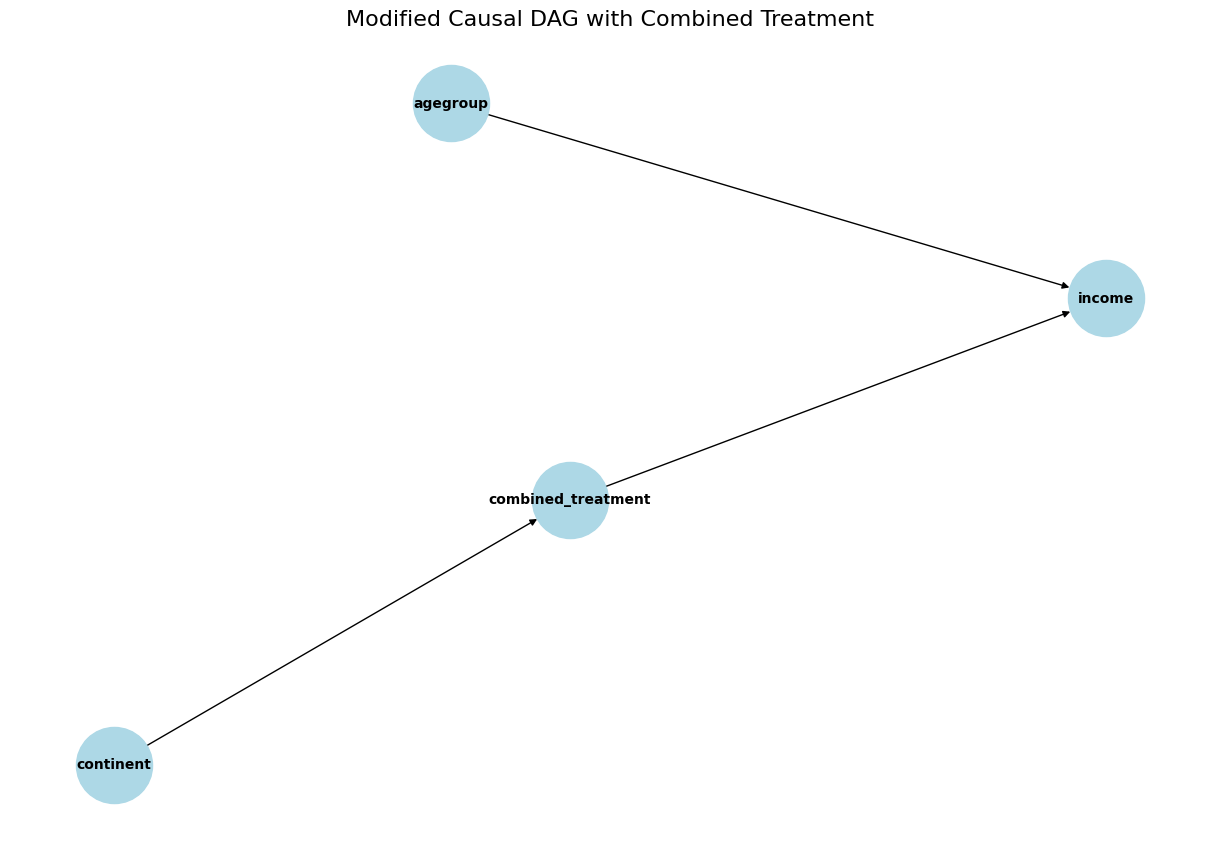

race=Black, gender=Male: 2287
Not (race=Black, gender=Male): 45698
Treatment: race=Black, gender=Male, ATE: -0.11893991278992933, p-value: [7.54722836e-11]
race=Black, gender=Female: 2266
Not (race=Black, gender=Female): 45719
Treatment: race=Black, gender=Female, ATE: -0.3812029766160303, p-value: [3.25944306e-96]
race=White, gender=Male: 28319
Not (race=White, gender=Male): 19666
Treatment: race=White, gender=Male, ATE: 0.3712846623430652, p-value: [0.]
race=White, gender=Female: 12870
Not (race=White, gender=Female): 35115
Treatment: race=White, gender=Female, ATE: -0.3301179242230057, p-value: [0.]
race=Other, gender=Male: 238
Not (race=Other, gender=Male): 47747
Treatment: race=Other, gender=Male, ATE: -0.16784916576218312, p-value: [0.00245732]
race=Other, gender=Female: 144
Not (race=Other, gender=Female): 47841
Treatment: race=Other, gender=Female, ATE: -0.3400726712791686, p-value: [1.77128232e-06]
race=Amer-Indian-Eskimo, gender=Male: 285
Not (race=Amer-Indian-Eskimo, gender=

{('Black', 'Male'): <dowhy.causal_estimator.CausalEstimate at 0x79d6040c4730>,
 ('Black',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x79d6042f1cc0>,
 ('White', 'Male'): <dowhy.causal_estimator.CausalEstimate at 0x79d652399960>,
 ('White',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x79d60de69270>,
 ('Other', 'Male'): <dowhy.causal_estimator.CausalEstimate at 0x79d60dedee90>,
 ('Other',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x79d60de68a00>,
 ('Amer-Indian-Eskimo',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x79d605396f50>,
 ('Amer-Indian-Eskimo',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x79d605394d90>,
 ('Asian-Pac-Islander',
  'Male'): <dowhy.causal_estimator.CausalEstimate at 0x79d60dfc5e70>,
 ('Asian-Pac-Islander',
  'Female'): <dowhy.causal_estimator.CausalEstimate at 0x79d605380280>}

In [55]:
get_two_feature_combination_ate(adult_dataset, dag, 'race', 'gender')

In [77]:
def check_synthesized_samples_effect_two_features(dataset, dag, feature_1, feature_2, synthesized_samples_file_path):
    # Load the synthesized samples csv
    synthesized_samples = pd.read_csv(synthesized_samples_file_path)

    # Take only the relevant features from synthesized samples
    synthesized_samples = synthesized_samples[[col for col in synthesized_samples.columns if col in dataset.columns]]

    # Combine the original dataset and synthesized samples
    data = dataset.copy()
    data = pd.concat([data, synthesized_samples])

    data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else -1)


    # Get unique possible values for both features
    possible_values_1 = data[feature_1].unique()
    possible_values_2 = data[feature_2].unique()

    # Dictionary to store causal estimates for synthesized data
    treatment_to_causal_estimate_dict_synthesized = {}

    for value_1 in possible_values_1:
        for value_2 in possible_values_2:
            data_copy = data.copy()
            # Create a new column that is 1 if both features match the specific combination of values, otherwise 0
            data_copy['combined_treatment'] = data_copy.apply(lambda row: 1 if (row[feature_1] == value_1 and row[feature_2] == value_2) else 0, axis=1)

            # Drop the original feature_1 and feature_2 columns
            data_copy = data_copy.drop([feature_1, feature_2], axis=1)

            # Modify DAG to combine the two features
            new_dag = causal_dag_manipulation(dag, feature_1, feature_2)
            dag = nx.DiGraph(new_dag)

            # Causal model
            model = CausalModel(
                data=data_copy,
                treatment='combined_treatment',
                outcome='income',
                graph=dag
            )

            # Identify and estimate the effect
            identified_estimand = model.identify_effect()
            causal_estimate = model.estimate_effect(
                identified_estimand,
                method_name="backdoor.linear_regression",
                target_units="ate",
                effect_modifiers=[],
                test_significance=True
            )

            # Store the result in the dictionary
            treatment_to_causal_estimate_dict_synthesized[(value_1, value_2)] = causal_estimate

    # Compare synthesized sample results with original ATEs
    treatment_to_causal_estimate_dict_original = get_two_feature_combination_ate(dataset, dag, feature_1, feature_2)

    for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items():
        print(f'Treatment: {feature_1}={treatment[0]}, {feature_2}={treatment[1]}, ATE (Synthesized): {causal_estimate_synthesized.value}')
        print(f'Actual ATE: {treatment_to_causal_estimate_dict_original[treatment].value}')
        print(f'Error: {abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value)}')

    # Calculate and print the treatment with the highest error
    errors = [abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value)
              for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items()
              if is_treatment_significant(causal_estimate_synthesized) and is_treatment_significant(treatment_to_causal_estimate_dict_original[treatment])]


    if errors:
        max_error = max(errors)
        errors_without_max = [e for e in errors if e != max_error]
        if (len(errors_without_max)>=1):
          print(f'Second Max: {max(errors_without_max)}')


        min_error = min(errors)
        print(f'Max error: {max_error}')
        print(f'Treatment with max error: {[treatment for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items() if abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value) == max_error]}')

        print(f'Min error: {min_error}')
        print(f'Treatment with min error: {[treatment for treatment, causal_estimate_synthesized in treatment_to_causal_estimate_dict_synthesized.items() if abs(causal_estimate_synthesized.value - treatment_to_causal_estimate_dict_original[treatment].value) == min_error]}')

        print(f'Mean error: {np.mean(errors)}')
    else:
        print("No significant treatments found.")


[('continent', 'race'), ('race', 'income'), ('agegroup', 'income'), ('gender', 'race'), ('gender', 'income')]


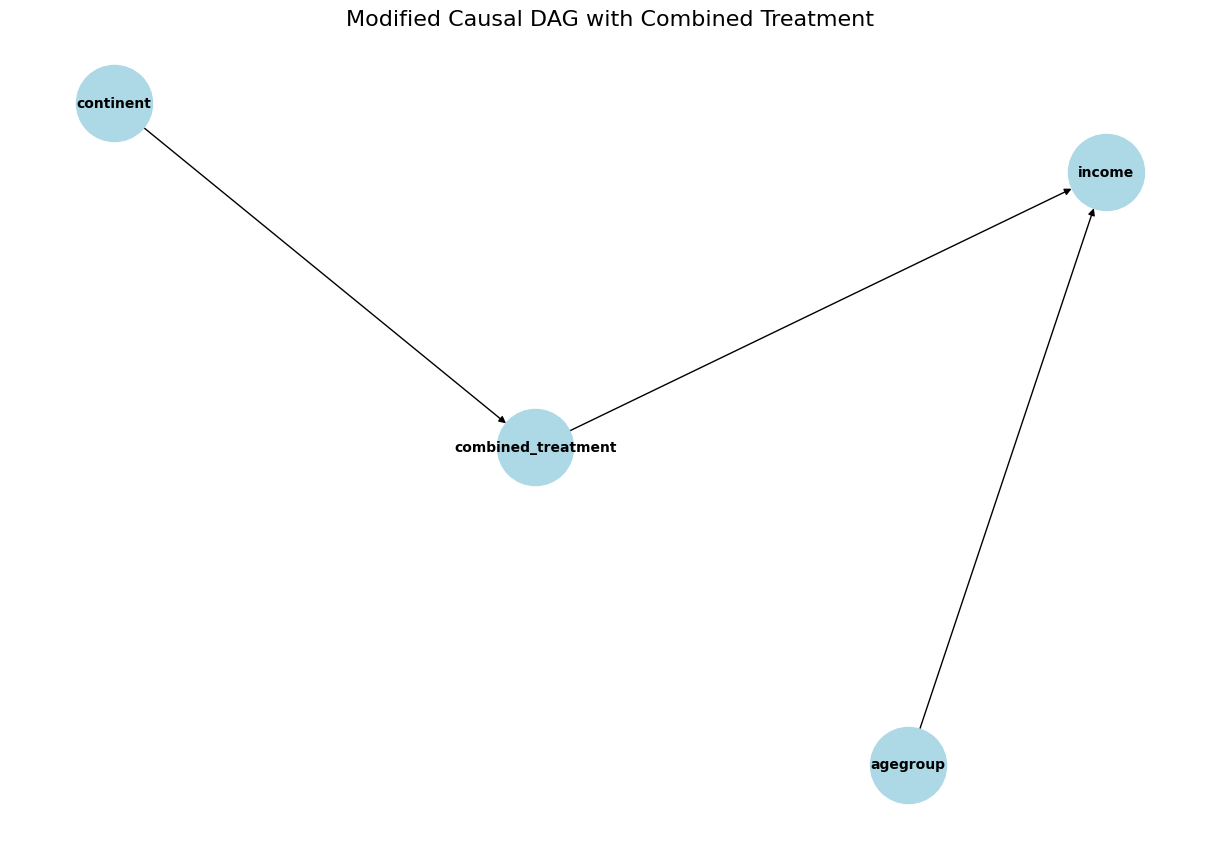

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


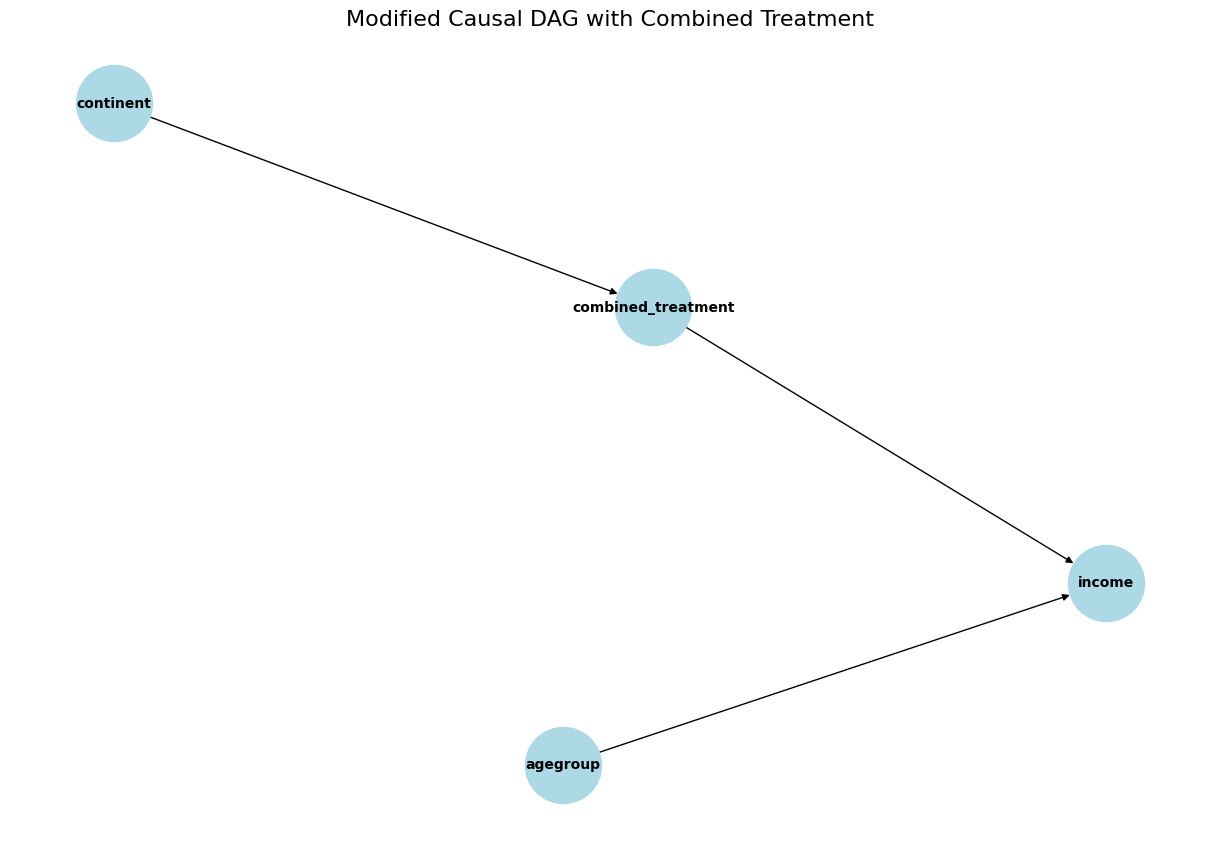

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


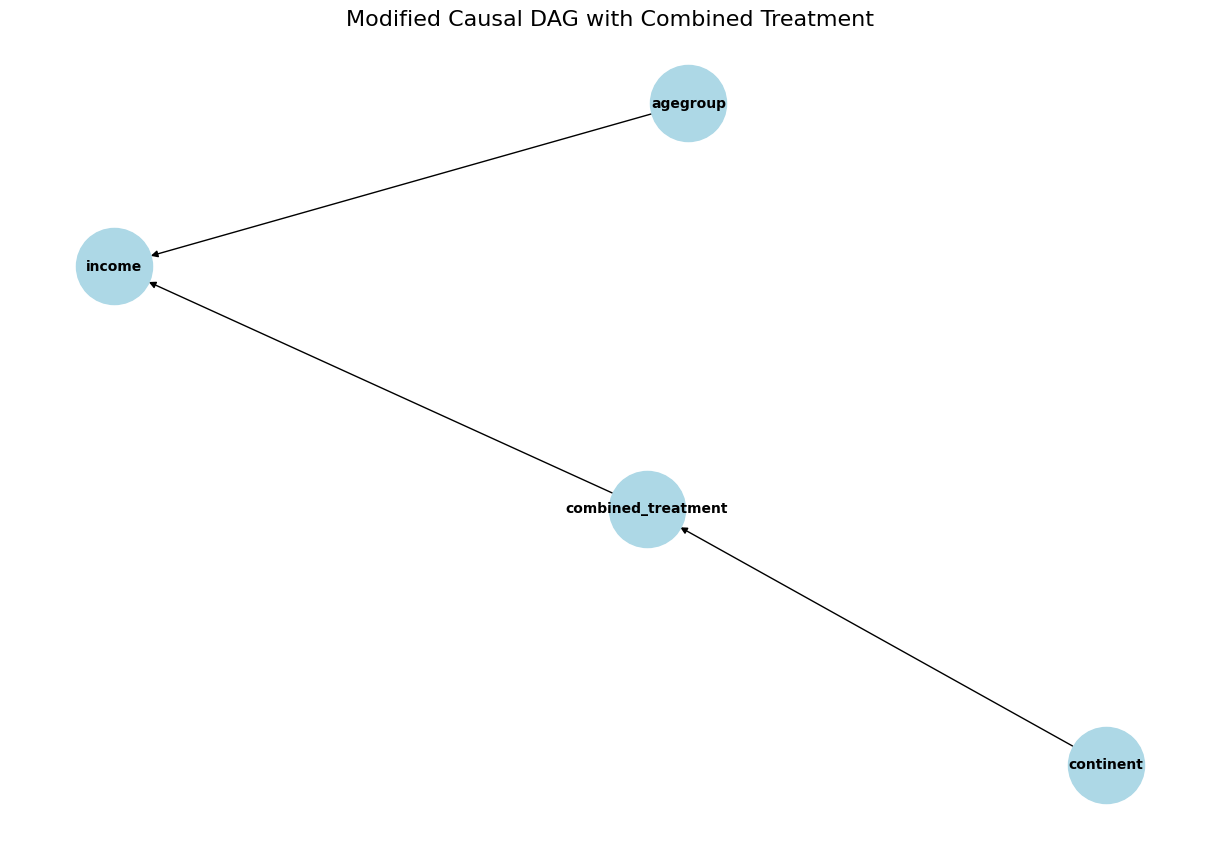

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


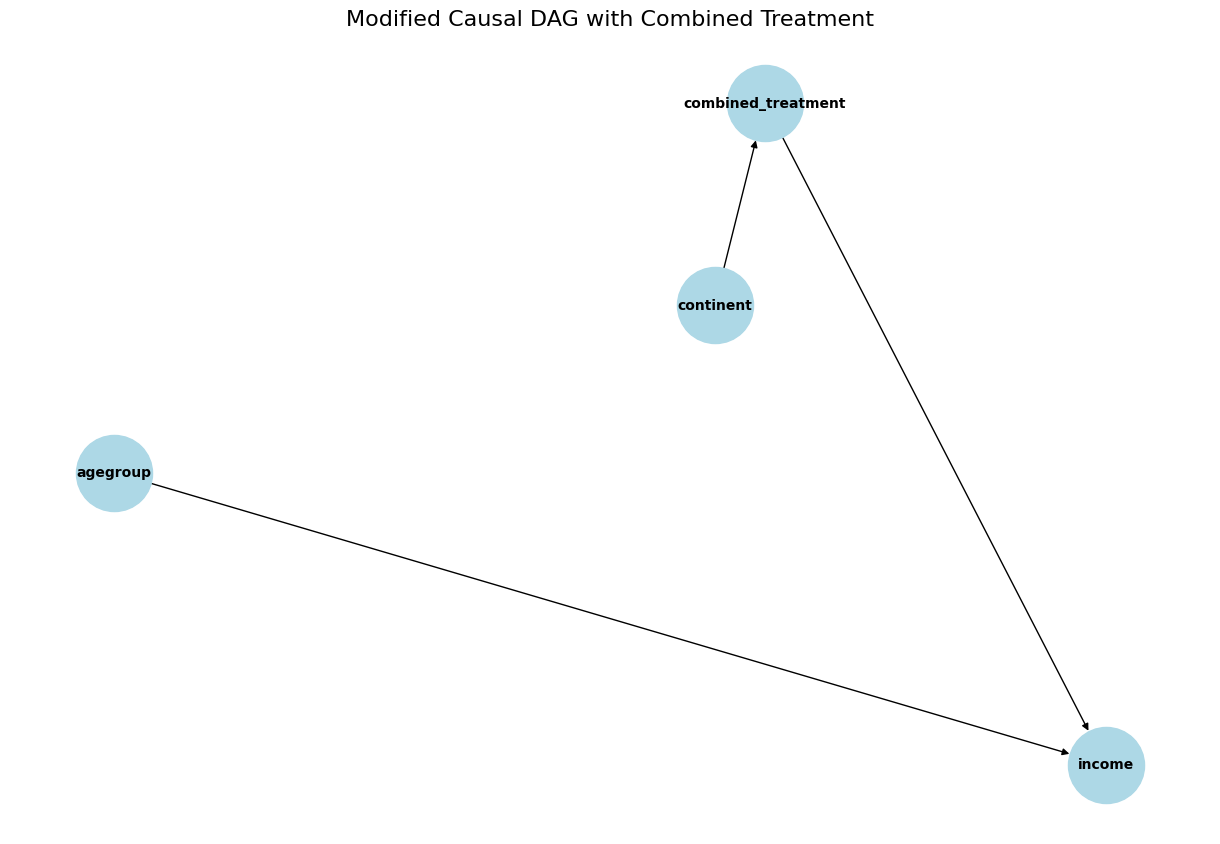

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


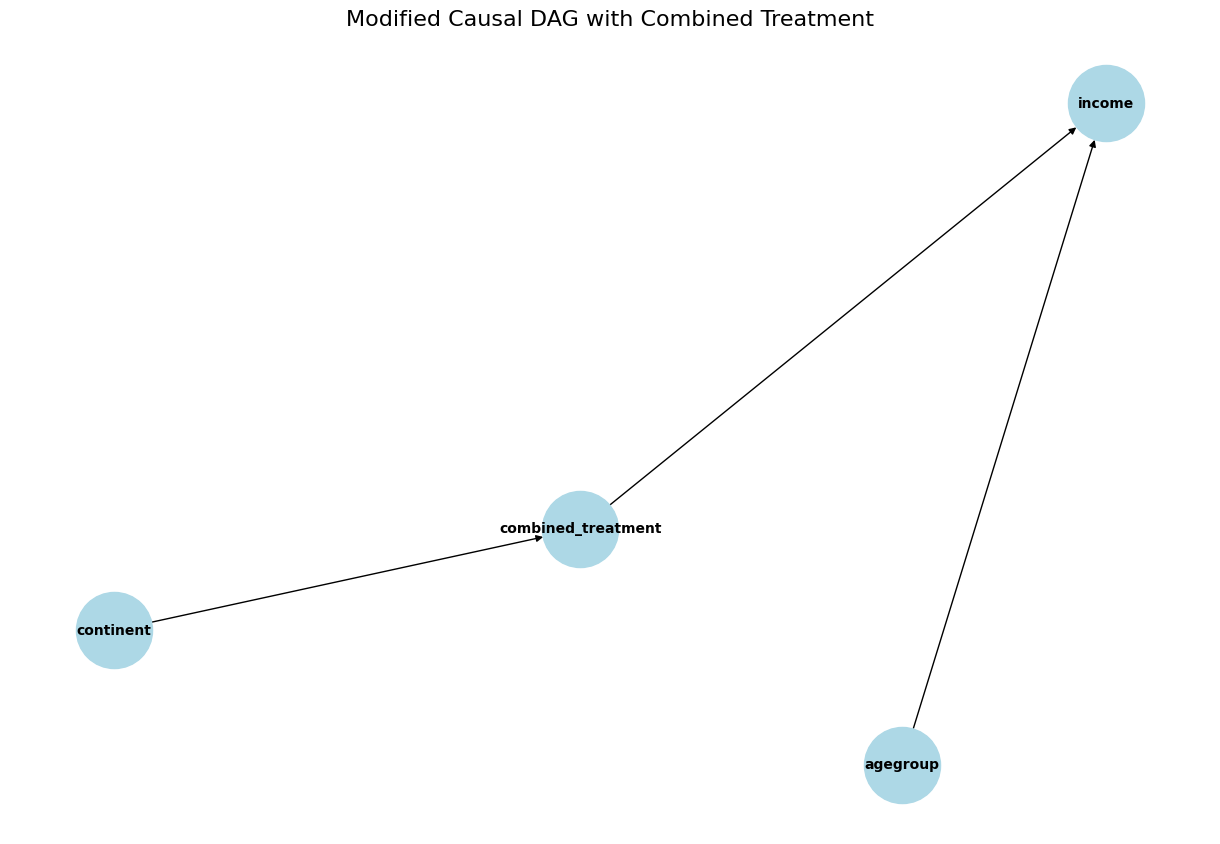

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


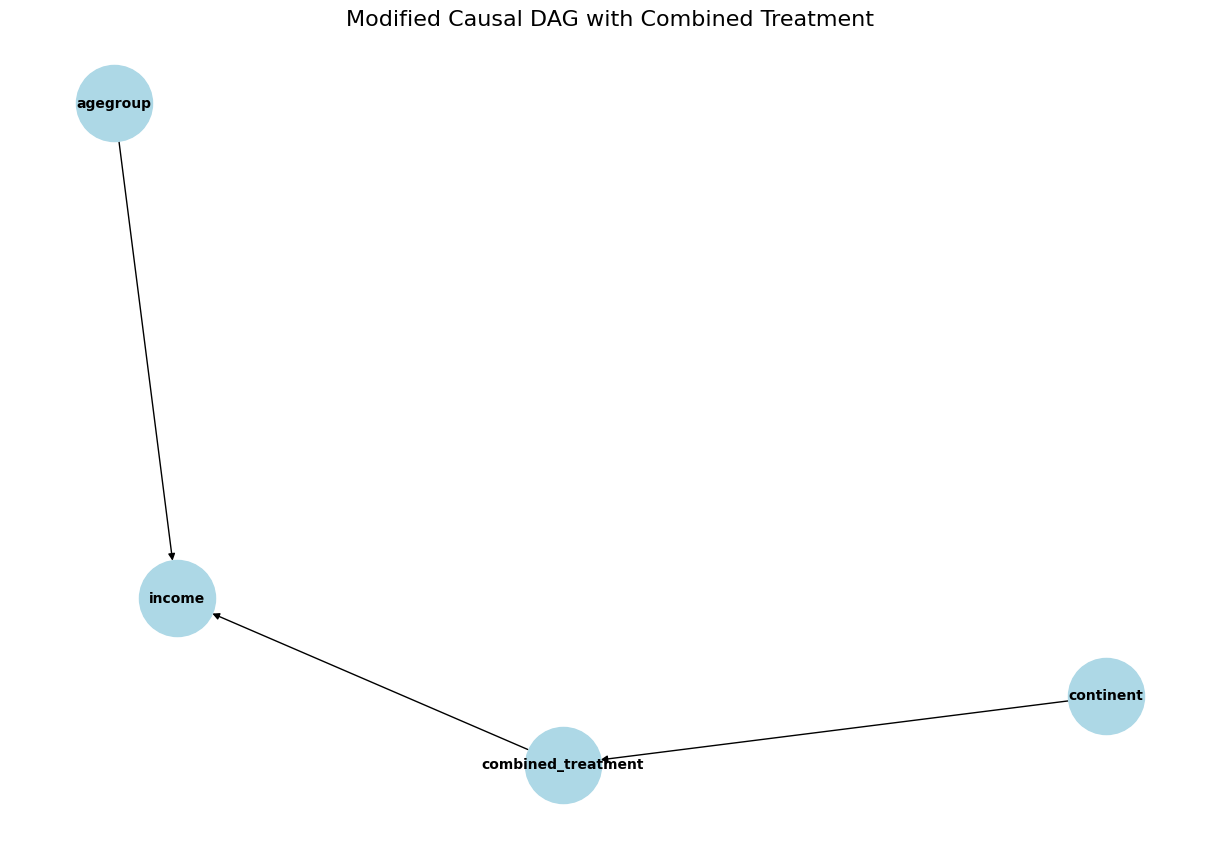

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


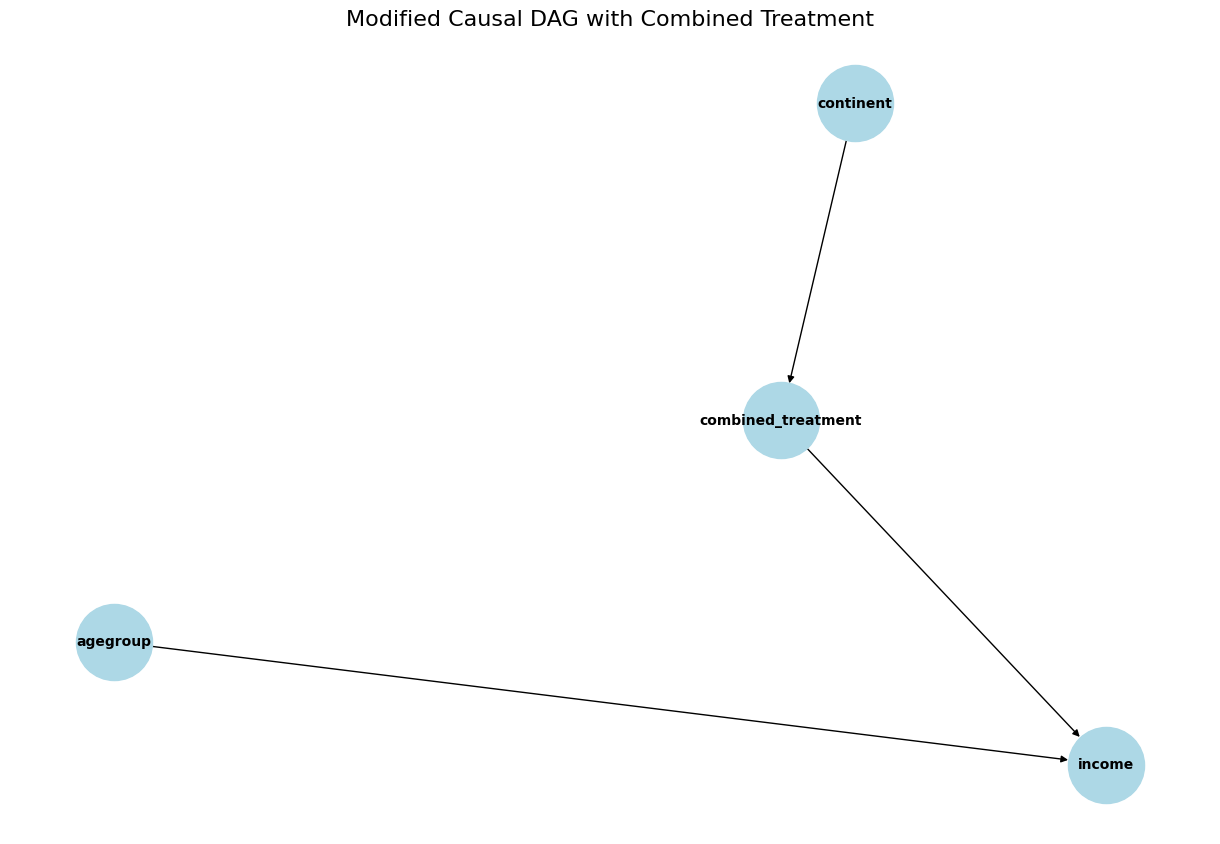

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


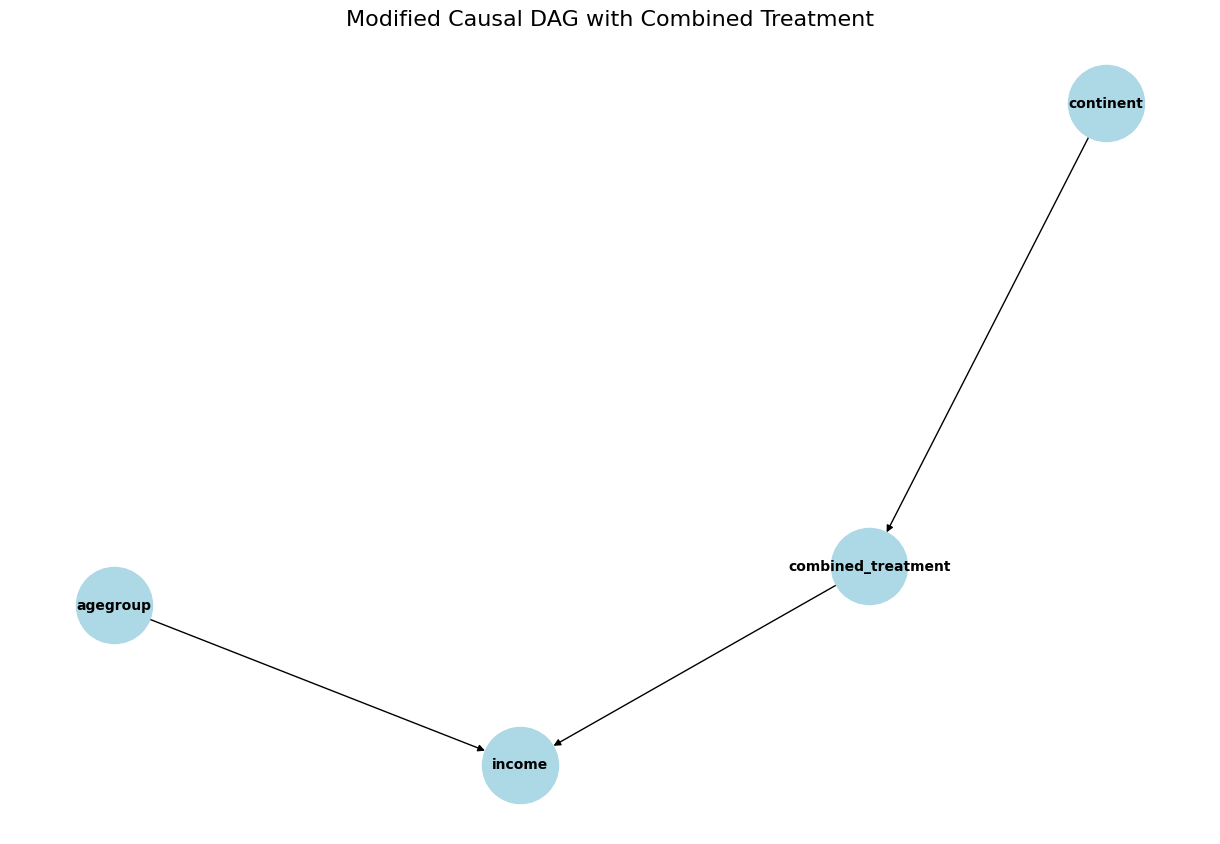

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


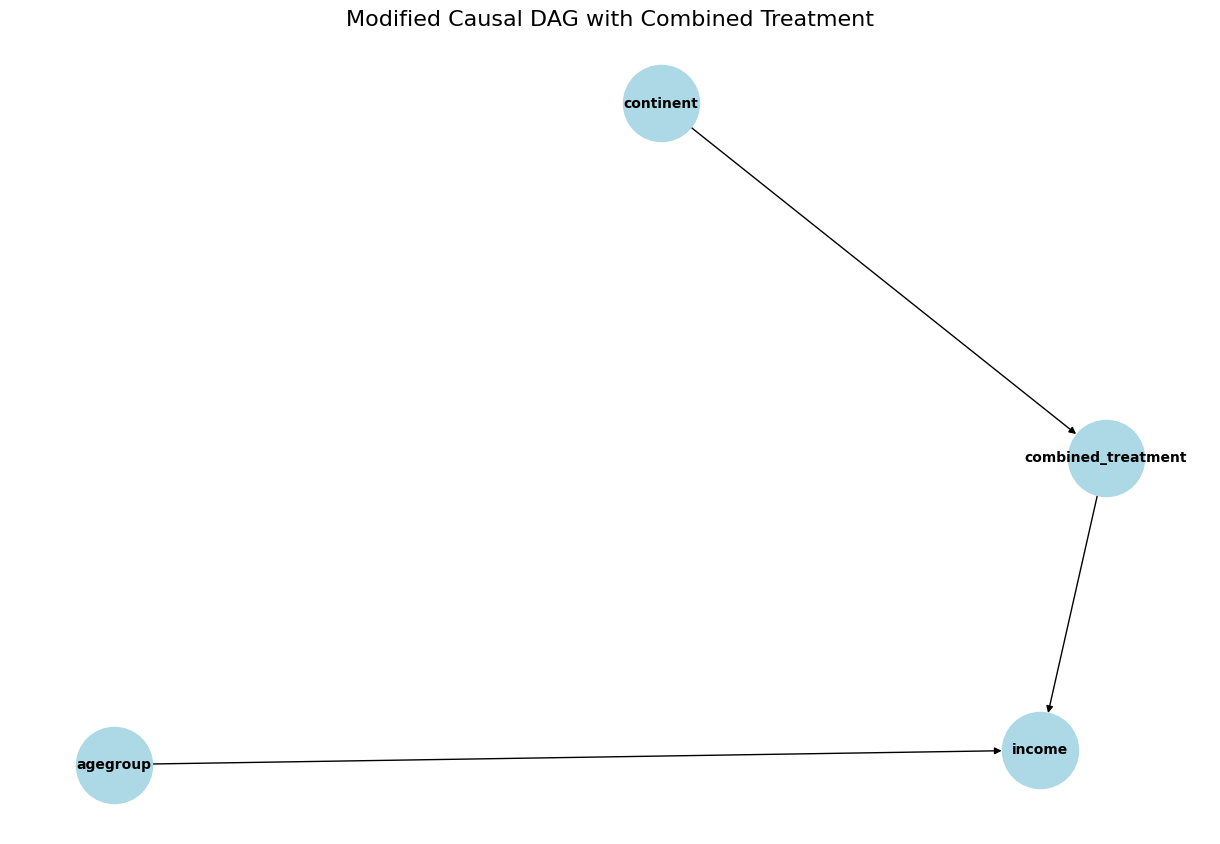

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


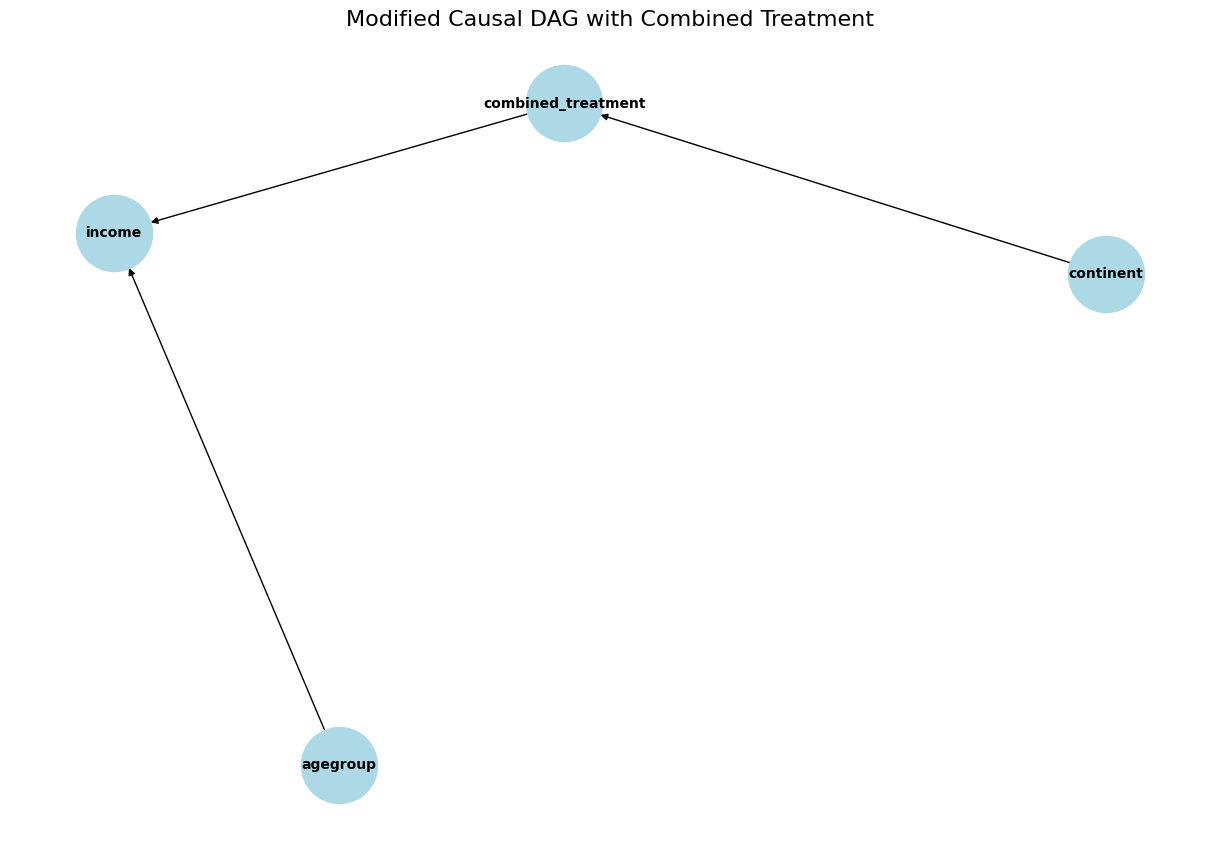

[('continent', 'combined_treatment'), ('combined_treatment', 'income'), ('agegroup', 'income')]


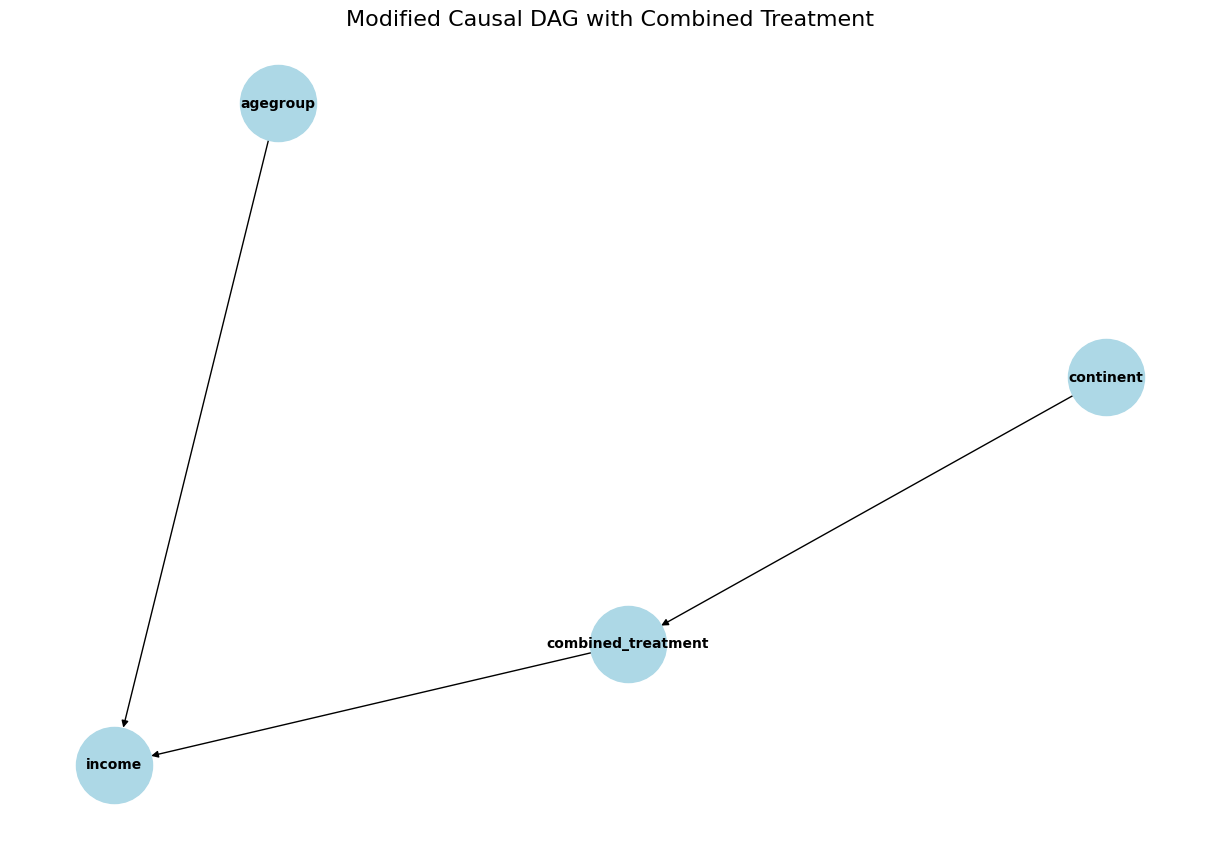

race=Black, gender=Male: 2287
Not (race=Black, gender=Male): 45698
Treatment: race=Black, gender=Male, ATE: -0.11893991278992933, p-value: [7.54722836e-11]
race=Black, gender=Female: 2266
Not (race=Black, gender=Female): 45719
Treatment: race=Black, gender=Female, ATE: -0.3812029766160303, p-value: [3.25944306e-96]
race=White, gender=Male: 28319
Not (race=White, gender=Male): 19666
Treatment: race=White, gender=Male, ATE: 0.3712846623430652, p-value: [0.]
race=White, gender=Female: 12870
Not (race=White, gender=Female): 35115
Treatment: race=White, gender=Female, ATE: -0.3301179242230057, p-value: [0.]
race=Other, gender=Male: 238
Not (race=Other, gender=Male): 47747
Treatment: race=Other, gender=Male, ATE: -0.16784916576218312, p-value: [0.00245732]
race=Other, gender=Female: 144
Not (race=Other, gender=Female): 47841
Treatment: race=Other, gender=Female, ATE: -0.3400726712791686, p-value: [1.77128232e-06]
race=Amer-Indian-Eskimo, gender=Male: 285
Not (race=Amer-Indian-Eskimo, gender=

In [78]:
synthesized_samples_file_path = f'./synthesized_samples_other_females.csv'
check_synthesized_samples_effect_two_features(adult_dataset, dag, 'race', 'gender', synthesized_samples_file_path)


In [ ]:
# Select features for clustering
scalar_features_for_voroni = ['age', 'educational-num']

# Prepare the data for clustering
X = adult_dataset[scalar_features_for_voroni].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans

# Set number of clusters
k = 10

# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
X['cluster'] = kmeans.fit_predict(X_scaled)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Assuming cluster_centers, X, and adult_dataset['cluster'] are defined correctly
# Create Voronoi diagram based on cluster centers in PCA space
vor = Voronoi(cluster_centers)
print("X Shape:", X.shape)
print("First few rows of X:\n", X.head())
# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the Voronoi diagram on the created axes
voronoi_plot_2d(
    vor,
    ax=ax,
    show_vertices=False,
    line_colors='orange',
    line_width=2,
    line_alpha=0.6,
    point_size=2
)

# Scatter plot of data points colored by cluster on the same axes
scatter = ax.scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=X['cluster'],
    cmap='viridis',
    alpha=0.5,
    label='Data Points'
)

# Scatter plot of cluster centers
ax.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='X',
    s=100,
    label='Cluster Centers'
)

# Adding title and labels
ax.set_title('k-Voronoi Diagram with k-Means Clusters (k=10)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Optional: Add a legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
# Calculate cluster sizes
cluster_sizes = X['cluster'].value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_sizes)

In [ ]:
# Define threshold for underrepresentation
threshold = 0.04 * len(X)  # 4% of the dataset

# Identify underrepresented clusters
underrepresented_clusters = cluster_sizes[cluster_sizes < threshold].index.tolist()
print("\nUnderrepresented Clusters:", underrepresented_clusters)

In [ ]:
# Inverse transform the scaled data to get original values
X[['age_original', 'education_num_original']] = scaler.inverse_transform(X_scaled)

# Analyze underrepresented clusters
for cluster in underrepresented_clusters:
    print(f"\nCluster {cluster} Summary:")
    cluster_data = X[X['cluster'] == cluster]
    print(cluster_data[['age_original', 'education_num_original']].describe())